# Appendix: Project template

We outline a structured approach for presenting research findings. The framework is divided into several key segments:

1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness 
1. Conclusion

The opening segment encompasses four essential elements:

- Contextual Background: What is the larger setting of the study? What makes this area of inquiry compelling? What are the existing gaps or limitations within the current body of research? What are some unanswered yet noteworthy questions?

- Project Contributions: What are the specific advancements made by this study, such as in data acquisition, algorithmic development, parameter adjustments, etc.?

- Summary of the main empirical results: What is the main statistical statement? is it significant (e.g. statistically or economically)? 

- Literature and Resource Citations: What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project? 

In the dataset profile, one should consider:

- The origin and composition of data utilized in the study. If the dataset is original, then provide the source code to ensure reproducibility.

- The chronological accuracy of the data points, verifying that the dates reflect the actual availability of information.

- A detailed analysis of descriptive statistics, with an emphasis on discussing the importance of the chosen graphs or metrics.

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.

- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.

# Intro

## Context

## Contributions

## Results Summary

## References

# Environment and global variable

In [5]:
#instal packages
!pip install mistralai transformers

In [19]:
#import packages
from mistralai import Mistral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm 
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import copy
from sklearn.metrics import accuracy_score

In [7]:
#whether to use mistral prompting or load datsets online
prompt_mistral = input("Do you want to use mistral prompting? (y/n): ") # or set to True
if prompt_mistral == 'y':
    prompt_mistral = True
else:
    prompt_mistral = False
    
if prompt_mistral:
    api_key_file = input("Enter the path to the API key file: ")
    with open(api_key_file, 'r') as file:
        api_key = file.read().strip()
        
else:
    api_key = None
    print("Using datasets on Yassine's webpage")

# Datasets

### FOMC Minutes and Statements dataset

- This is ad public dataset that is automatically scraping the Fed's website in order to append new statements and meeting minutes transcripts [github](https://github.com/vtasca/fed-statement-scraping)

In [43]:
# load comunications fomc
if os.path.exists('./communications.csv'):
    communications = pd.read_csv('./communications.csv')
    print('Dataset loaded.')
else:
    print('Installing dataset...')
    !curl -L -o ./fomc-meeting-statements-and-minutes.zip https://www.kaggle.com/api/v1/datasets/download/vladtasca/fomc-meeting-statements-and-minutes
    !unzip ./fomc-meeting-statements-and-minutes.zip -d ./fomc-meeting-statements-and-minutes
    !mv ./fomc-meeting-statements-and-minutes/communications.csv ./communications.csv
    !rm ./fomc-meeting-statements-and-minutes.zip
    !rm -r ./fomc-meeting-statements-and-minutes
    
    communications = pd.read_csv('./communications.csv')
    
communications['Date'] = pd.to_datetime(communications['Date'])
communications['Release Date'] = pd.to_datetime(communications['Release Date'])
    
print(f' Rows x Columns: {communications.shape}')
print(f' Columns: {communications.columns}')
print('------------------------')
print(f' This dataset contains two types of communications: {communications["Type"].unique()}')
print(f' Average lentgh of text by type of communication :\n {communications.groupby("Type")["Text"].apply(lambda x: x.str.len().mean())}')
print(f'-----------------------')
print(f'The dataset has two dates columns: {communications.columns[communications.columns.str.contains("date")]}')
mask = (communications["Type"] == "Statement") & (communications["Date"] != communications["Release Date"])
result = communications.loc[mask, ["Date", "Release Date"]]
print(f'For type="statement", "Date" is almost always equal to "Release Date", except for {len(result)} rows:\n {result}')

print(f'-----------------------')
print(f' The only NaN values are in the column {communications.columns[communications.isna().any()]}, specifically when "Type" is "Minutes"')
print(f'number of NaN values: {communications["Release Date"].isna().sum()}')
print(f'We can check the avergae difference between Release Date and Date for the Non NaN values')

minutes=communications[communications['Type']=='Minute']
#keep non na rows
minutes=minutes.dropna()
# Compute the differences
series = minutes['Release Date'] - minutes['Date']
mode=series.mode()[0],series.value_counts().max()

print(f' The mode of the difference between Release Date and Date for the Non NaN values is {mode[0]} with {mode[1]} occurences')
#fill NaN values with the mode
communications['Release Date']=communications['Release Date'].fillna(communications['Date']+pd.DateOffset(days=21))

Dataset loaded.
 Rows x Columns: (440, 4)
 Columns: Index(['Date', 'Release Date', 'Type', 'Text'], dtype='object')
------------------------
 This dataset contains two types of communications: ['Minute' 'Statement']
 Average lentgh of text by type of communication :
 Type
Minute       48114.781659
Statement     2667.734597
Name: Text, dtype: float64
-----------------------
The dataset has two dates columns: Index([], dtype='object')
For type="statement", "Date" is almost always equal to "Release Date", except for 1 rows:
          Date Release Date
86 2019-10-04   2019-10-11
-----------------------
 The only NaN values are in the column Index(['Release Date'], dtype='object'), specifically when "Type" is "Minutes"
number of NaN values: 29
We can check the avergae difference between Release Date and Date for the Non NaN values
 The mode of the difference between Release Date and Date for the Non NaN values is 21 days 00:00:00 with 141 occurences


### Georgia Tech's labelled Dataset

- This Dataset contains senteneces extracted from statements, meeting minutes and press conferences of the Fed. Where Two human annotators tried to label the text as Hawkish, dovish or neutral

In [81]:
#Load Georgia Tech's dataset
splits = {'train': 'train.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/gtfintechlab/fomc_communication/" + splits["train"])
df_test = pd.read_csv("hf://datasets/gtfintechlab/fomc_communication/" + splits["test"])

georgia_tech_df = pd.concat([df_train, df_test], axis=0)

print(f' Rows x Columns: {georgia_tech_df.shape}')
print(f' Columns: {georgia_tech_df.columns}')
print('------------------------')
print(f' This dataset contains 3 labels: {georgia_tech_df["label"].unique()}. 0: dovish, 1: hawkish, 2: neutral')
print(f' Counts for each label:\n {georgia_tech_df["label"].value_counts()} \n Twice as many neutral as the others')

print(f' Average length of text by label :\n {georgia_tech_df.groupby("label")["sentence"].apply(lambda x: x.str.len().mean())}')

 Rows x Columns: (2480, 5)
 Columns: Index(['index', 'sentence', 'year', 'label', 'orig_index'], dtype='object')
------------------------
 This dataset contains 3 labels: [2 0 1]. 0: dovish, 1: hawkish, 2: neutral
 Counts for each label:
 2    1224
0     650
1     606
Name: label, dtype: int64 
 Twice as many neutral as the others
 Average length of text by label :
 label
0    201.173846
1    191.333333
2    192.319444
Name: sentence, dtype: float64


We see that this dataset has a few imbalances when it comes to label distributions. It also is trained to label sentences and not Long paragraphs

### ST. Louis Federal Reserve bank data

- As the Fed's monetary stances reflects their intentions with the US economy. We were interested in trying to get insights on the stance by looking at economical data

- [Interest rates](https://fred.stlouisfed.org/series/INTDSRUSM193N)

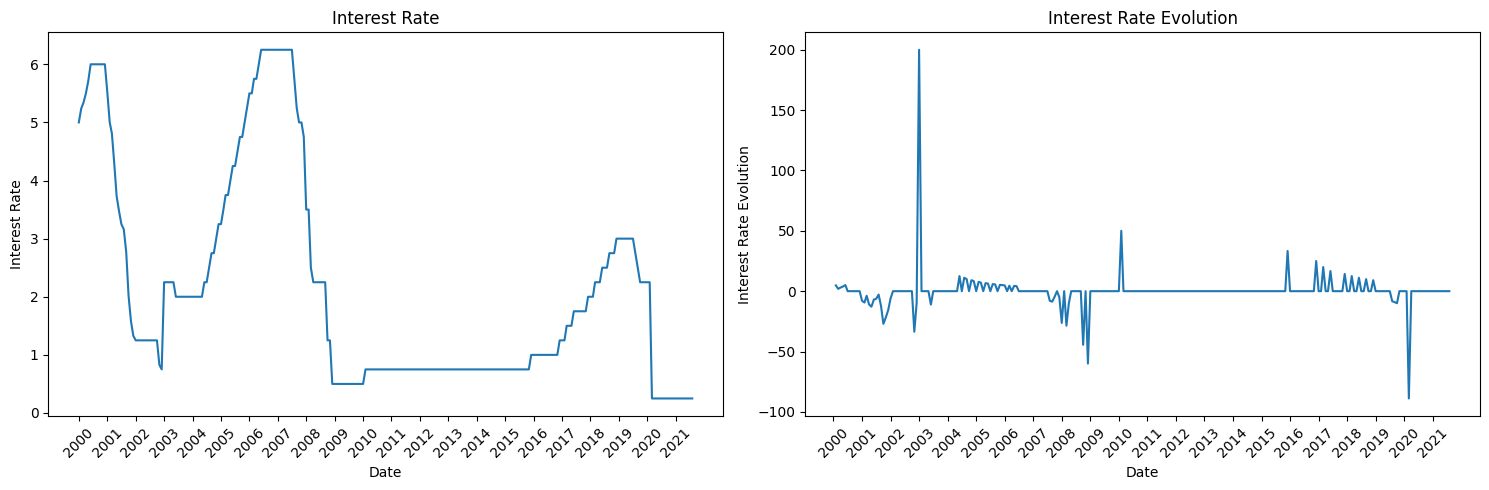

In [10]:
#Load interest rate Data
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=INTDSRUSM193N&scale=left&cosd=1950-01-01&coed=2021-08-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1950-01-01"

#Interest Rates, Discount Rate for United States

# Download the CSV file into a DataFrame
Int_R = pd.read_csv(csv_url)
#keep observations from 2000 onwards
Int_R=Int_R[Int_R['observation_date']>='2000-01-01']
Int_R['evolution']=Int_R['INTDSRUSM193N'].diff(1)
Int_R['evolution_pct']=Int_R['INTDSRUSM193N'].pct_change(1)*100
Int_R['observation_date'] = pd.to_datetime(Int_R['observation_date'])
jan_first_dates = Int_R['observation_date'][Int_R['observation_date'].dt.strftime('%m-%d') == '01-01']
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Int_R['observation_date'], Int_R['INTDSRUSM193N'])
ax[0].set_title('Interest Rate')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest Rate')
ax[0].set_xticks(jan_first_dates)
ax[0].set_xticklabels(jan_first_dates.dt.year, rotation=45)

ax[1].plot(Int_R['observation_date'], Int_R['evolution_pct'])
ax[1].set_title('Interest Rate Evolution')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest Rate Evolution')
ax[1].set_xticks(jan_first_dates)
ax[1].set_xticklabels(jan_first_dates.dt.year, rotation=45)
plt.tight_layout()
plt.show()


- [Consumer Price Index](https://fred.stlouisfed.org/series/CPIAUCSL) 

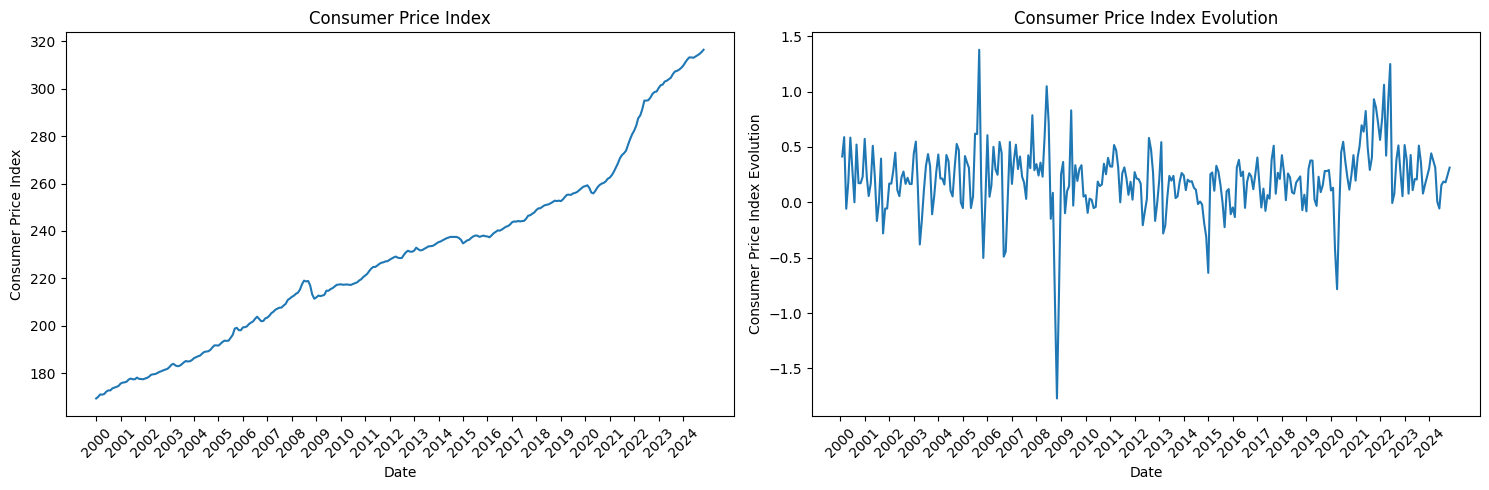

In [11]:
#consumer price index
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1947-01-01&coed=2024-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1947-01-01"

#Consumer Price Index for All Urban Consumers: All Items in U.S. City Average

# Download the CSV file into a DataFrame
CPI = pd.read_csv(csv_url)
#keep observations from 2000 onwards
CPI=CPI[CPI['observation_date']>='2000-01-01']
CPI['evolution']=CPI['CPIAUCSL'].diff(1)
CPI['evolution_pct']=CPI['CPIAUCSL'].pct_change(1)*100
CPI['observation_date'] = pd.to_datetime(CPI['observation_date'])
jan_first_dates_CPI = CPI['observation_date'][CPI['observation_date'].dt.strftime('%m-%d') == '01-01']

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(CPI['observation_date'], CPI['CPIAUCSL'])
ax[0].set_title('Consumer Price Index')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Consumer Price Index')
ax[0].set_xticks(jan_first_dates_CPI)
ax[0].set_xticklabels(jan_first_dates_CPI.dt.year, rotation=45)

ax[1].plot(CPI['observation_date'], CPI['evolution_pct'])
ax[1].set_title('Consumer Price Index Evolution')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Consumer Price Index Evolution')
ax[1].set_xticks(jan_first_dates_CPI)
ax[1].set_xticklabels(jan_first_dates_CPI.dt.year, rotation=45)
plt.tight_layout()
plt.show()


- [Unemployment Rate](https://fred.stlouisfed.org/series/UNRATE)

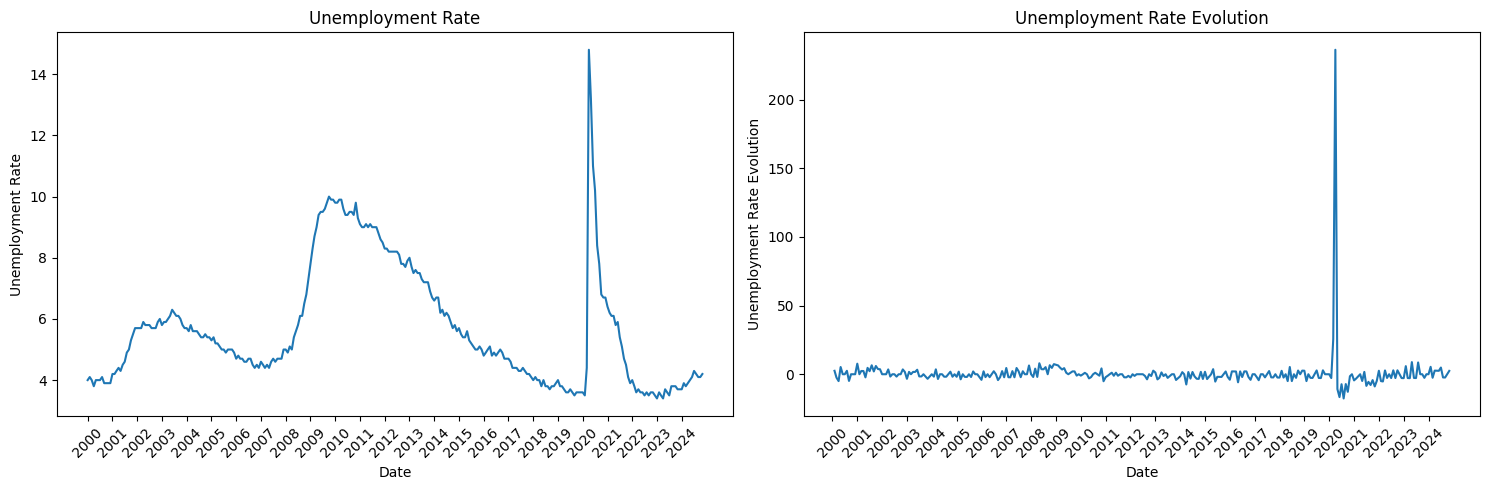

In [12]:
#Unemployment rate
# Define the URL for the CSV download
csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=UNRATE&scale=left&cosd=1948-01-01&coed=2024-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-12-18&revision_date=2024-12-18&nd=1948-01-01"

#Unepmloyment Rate

# Download the CSV file into a DataFrame
UR = pd.read_csv(csv_url)
#keep observations from 2000 onwards
UR=UR[UR['observation_date']>='2000-01-01']
UR['evolution']=UR['UNRATE'].diff(1)
UR['evolution_pct']=UR['UNRATE'].pct_change(1)*100
UR['observation_date'] = pd.to_datetime(UR['observation_date'])
jan_first_dates_UR = UR['observation_date'][UR['observation_date'].dt.strftime('%m-%d') == '01-01']

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(UR['observation_date'], UR['UNRATE'])
ax[0].set_title('Unemployment Rate')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Unemployment Rate')
ax[0].set_xticks(jan_first_dates_UR)
ax[0].set_xticklabels(jan_first_dates_UR.dt.year, rotation=45)

ax[1].plot(UR['observation_date'], UR['evolution_pct'])
ax[1].set_title('Unemployment Rate Evolution')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Unemployment Rate Evolution')
ax[1].set_xticks(jan_first_dates_UR)
ax[1].set_xticklabels(jan_first_dates_UR.dt.year, rotation=45)
plt.tight_layout()
plt.show()


### Chronlogical Accuracy

The biggest problem with Georgia Tech's dataset is that after extracting small sentences to label, They only kept the year

Years available in Georgia Tech's dataset: [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


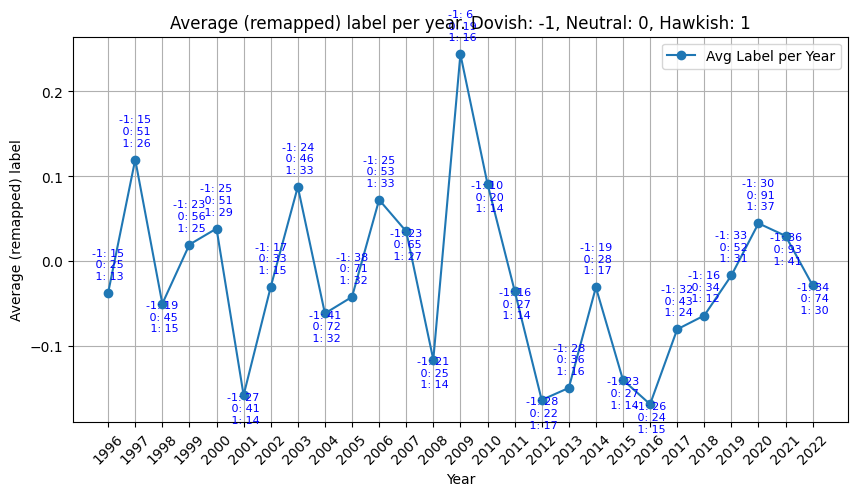

In [ ]:
# years available in Georgia Tech's dataset
years = georgia_tech_df['year'].unique()
print(f'Years available in Georgia Tech\'s dataset: {sorted(years)}')

georgia_tech_df['label_mapped'] = georgia_tech_df['label'].map({0: -1, 1: 1, 2: 0})
#average label per year
avg_label_per_year = georgia_tech_df.groupby('year')['label_mapped'].mean()
# Calculate counts of each label per year
counts_per_year = georgia_tech_df.groupby(['year', 'label_mapped']).size().unstack(fill_value=0)

# Prepare the years and counts for plotting
years = sorted(georgia_tech_df['year'].unique())
counts_dict = counts_per_year.to_dict(orient='index')

# Plot average label per year
plt.figure(figsize=(10, 5))
plt.plot(avg_label_per_year, marker='o', label='Avg Label per Year')
plt.title('Average (remapped) label per year. Dovish: -1, Neutral: 0, Hawkish: 1')
plt.xlabel('Year')
plt.ylabel('Average (remapped) label')
plt.xticks(years, rotation=45)
plt.grid()

# Annotate with counts
prev_avg = None
for i, year in enumerate(years):
    avg = avg_label_per_year.loc[year]
    counts = counts_dict.get(year, {})
    label_text = (
        f"-1: {counts.get(-1, 0)}\n"
        f" 0: {counts.get(0, 0)}\n"
        f" 1: {counts.get(1, 0)}"
    )
    
    # Determine placement based on slope or position
    if i > 0:
        prev_avg = avg_label_per_year.loc[years[i - 1]]
        slope = avg - prev_avg
        if slope > 0:
            xytext = (0, 10)  # Place above for upward slope
        else:
            xytext = (0, -20)  # Place below for downward slope
    else:
        xytext = (0, 10)  # Default for the first point
    
    plt.annotate(
        label_text,
        (year, avg),
        textcoords="offset points",
        xytext=xytext,
        ha="center",
        fontsize=8,
        color='blue'
    )

plt.legend()
plt.show()

Each year the neutral label is still predominant compared to the other two which means it's gard to try and get a trend from this graph. Which is something we would have liked to cross-validate future resuluts

#### Fred Data

The Time series displayed above are updated Monthly on the 1st of January.

In [55]:
print(f'Time period covered by interest rate data: {Int_R["observation_date"].min()} to {Int_R["observation_date"].max()}')
print(f'Time period covered by consumer price index data: {CPI["observation_date"].min()} to {CPI["observation_date"].max()}')
print(f'Time period covered by unemployment rate data: {UR["observation_date"].min()} to {UR["observation_date"].max()}')

Time period covered by interest rate data: 2000-01-01 00:00:00 to 2021-08-01 00:00:00
Time period covered by consumer price index data: 2000-01-01 00:00:00 to 2024-11-01 00:00:00
Time period covered by unemployment rate data: 2000-01-01 00:00:00 to 2024-11-01 00:00:00


#### Fomc Period and updates

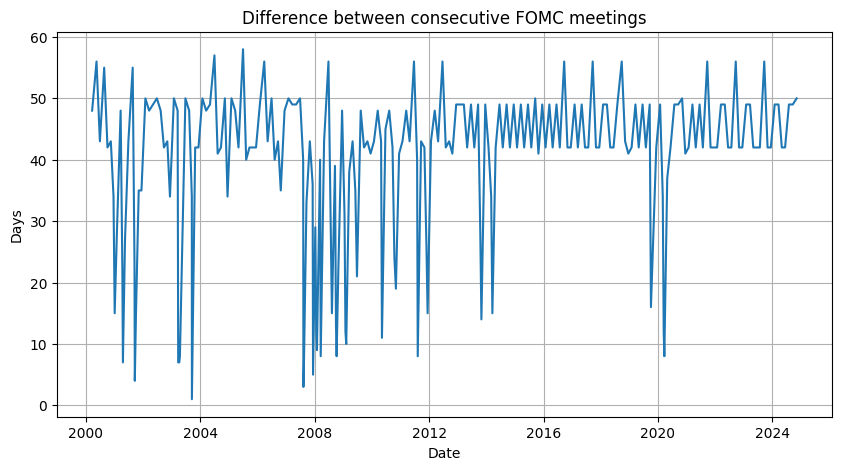

In [56]:
#plot the difference betwwen consecutive fomc meetings
#group by date
communications_grouped = communications.groupby('Date').first()
#sort by date
communications_grouped = communications_grouped.sort_index()
#compute the difference between consecutive dates
communications_grouped['diff'] = communications_grouped.index.to_series().diff()
#plot the difference
plt.figure(figsize=(10, 5))
plt.plot(communications_grouped.index, communications_grouped['diff'].dt.days)
plt.title('Difference between consecutive FOMC meetings')
plt.xlabel('Date')
plt.ylabel('Days')
plt.grid()
plt.show()


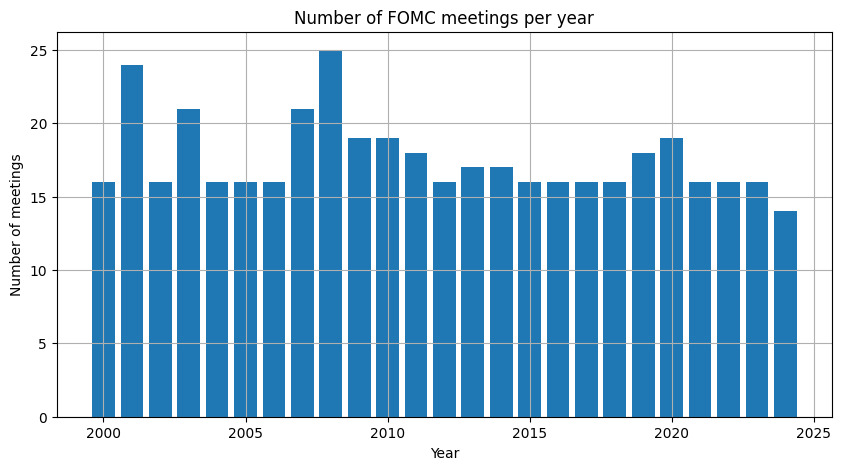

In [57]:
#plot number of eeting per year
communications['year'] = communications['Date'].dt.year
meetings_per_year = communications.groupby('year').size()
plt.figure(figsize=(10, 5))
plt.bar(meetings_per_year.index, meetings_per_year)
plt.title('Number of FOMC meetings per year')
plt.xlabel('Year')
plt.ylabel('Number of meetings')
plt.grid()
plt.show()


# Machine Learning models

In the next cell we create a bunch of functions:

##### `get_variable_name(var)`
- **Description**: Retrieves the name of a variable as a string.
- **Usage**: Helps identify the variable name dynamically during runtime.

---

##### `analyze_monetary_policy(df, api_key, prompt_mistral=True, use_checkpoints=True)`
- **Description**: Analyzes the hawkishness of monetary policy statements using Mistral API.
- **Inputs**: 
  - `df`: Input DataFrame (e.g., communications or Georgia Tech dataset).
  - `api_key`: API key for the Mistral model.
  - `prompt_mistral`: If `True`, directly uses Mistral for analysis.
  - `use_checkpoints`: If `True`, uses saved checkpoints to avoid reprocessing.
- **Outputs**: Returns a DataFrame with analysis results.

-  Prompt used : ```{
                      "role": "user",
                      "content": f"Act as a financial analyst. What is the monetary policy hawkishness of this text? \
      Please choose an answer from hawkish, dovish, neutral or unknown and provide a probability and a short explanation. \
          answer in this structure (no other text) : \n \
          label: hawkish, \n probability: 90%, \n explanation: The text contains a lot of positive words and is likely to be hawkish. \n \
      Text: {text}"}```
---

##### `extract_label(text, numeric=False)`
- **Description**: Extracts the monetary policy label (hawkish, dovish, neutral, or unknown) from a text response.
- **Inputs**: 
  - `text`: Response text containing the label.
  - `numeric`: If `True`, converts labels to numeric format (1, 0, -1).
- **Outputs**: Returns the extracted label.

---

##### `process_checkpoint(checkpoint, source_df)`
- **Description**: Processes checkpoint data and integrates it into the source DataFrame with labels and explanations.
- **Inputs**: 
  - `checkpoint`: DataFrame containing Mistral responses.
  - `source_df`: Original dataset for integration.
- **Outputs**: Updated DataFrame with labels and explanations.

---

##### `check_important_shift_dates(df, steps)`
- **Description**: Identifies dates with significant shifts in monetary policy labels over a defined step range.
- **Inputs**: 
  - `df`: DataFrame containing monetary policy labels.
  - `steps`: Number of steps to check for consecutive shifts.
- **Outputs**: Boolean condition identifying significant shifts.

---

##### `plot_monetary_policy(df, label)`
- **Description**: Plots the hawkishness of monetary policy over time, highlighting important shifts.
- **Inputs**: 
  - `df`: DataFrame containing monetary policy data with dates and labels.
  - `label`: Column name for the labels to be plotted.
- **Outputs**: Displays a plot with separate subplots for different statement types and combined data.

In [145]:
def get_variable_name(var):
    return [name for name in globals() if globals()[name] is var][0]


def analyze_monetary_policy(df,api_key,prompt_mistral=prompt_mistral,use_checkpoints=True,data_name=None):
    df_name = data_name if data_name else get_variable_name(df)
    if not prompt_mistral:
        if df_name == 'communications':
            checkpoint = pd.read_csv('https://MachtaYassine.github.io/datasets/communications-mistral-prompted.csv',sep=';')
        elif df_name == 'georgia_tech_df':
            checkpoint = pd.read_csv('https://MachtaYassine.github.io/datasets/Georgia_tech_dataset-mistral-prompted.csv',sep=';')
        else:
            raise ValueError('The dataset is not recognized. Please set prompt_mistral to True.')
        return checkpoint
    model = "mistral-large-latest"
    client = Mistral(api_key=api_key)
    df_name = get_variable_name(df)
    if use_checkpoints and os.path.exists(f'{df_name}_checkpoint.csv'):
        checkpoint = pd.read_csv(f'{df_name}_checkpoint.csv')
        print(f"Checkpoint load with {len(checkpoint)} rows out of {len(df)}.")
    else:
        checkpoint = pd.DataFrame(columns=['text'])

    if df_name == 'communications':
        values=df['Text'].values
    elif df_name == 'georgia_tech_df':
        values=df['sentence'].values
    else:
        raise ValueError('The dataset is not recognized. Please Modify this line')
    
    for text in tqdm(values[len(checkpoint):]):
        chat_response = client.chat.complete(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": f"Act as a financial analyst. What is the monetary policy hawkishness of this text? \
    Please choose an answer from hawkish, dovish, neutral or unknown and provide a probability and a short explanation. \
        answer in this structure (no other text) : \n \
        label: hawkish, \n probability: 90%, \n explanation: The text contains a lot of positive words and is likely to be hawkish. \n \
    Text: {text}",
                },
            ]
        )

        response_message = chat_response.choices[0].message.content
        

        checkpoint = pd.concat([checkpoint,pd.DataFrame({'text':[response_message]})])
        time.sleep(2)
        checkpoint.to_csv(f'{df_name}_checkpoint.csv',index=False)
    
    return checkpoint


def extract_label(text,numeric=False):
    if text.find("hawkish") != -1:
        return "hawkish" if not numeric else 1
    elif text.find("dovish") != -1:
        return "dovish" if not numeric else 0
    elif text.find("neutral") != -1:
        return "neutral" if not numeric else 2
    else:
        return "unknown" if not numeric else 2
    
def process_checkpoint(checkpoint,source_df):
    source_df.loc[:, 'label'] = checkpoint['text'].apply(extract_label)
    source_df.loc[:, 'Mistral_explanation'] = checkpoint['text'].apply(lambda x: x.split('explanation: ')[1].strip() if x.find('explanation') != -1 else x.split('Explanation: ')[1].strip())

    return source_df

def check_important_shift_dates(df,steps):
    sub_df= df[df['Type']=='Statement']
    cond=(np.abs(sub_df['label2'].diff(1))>0)
    # print(np.unique(np.abs(sub_df['label2'].diff(1)),return_counts=True))
    for step in range(2,steps+1):
        # print(np.unique(np.abs(sub_df['label2'].diff(step)),return_counts=True))
        cond=cond & (np.abs(sub_df['label2'].diff(step))>0)
    return sub_df['Date2'][cond].values


def plot_monetary_policy(df,label):
    # Ensure Date2 is datetime and sorted
    df.loc[:, 'Date2'] = pd.to_datetime(df['Release Date'])

    df = df.sort_values(by='Date2', ascending=False)

    # Encode labels
    df['label2'] = df[label].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'neutral' else -1)

    # Identify important shifts
    Dates = check_important_shift_dates(df, 3)

    # Initialize subplots
    fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

    # Plot each statement type separately
    for ax, (statement_type, group_df) in zip(axes[:2], df.groupby('Type')):
        ax.plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
        ax.set_title(f'{statement_type} Statements')
        ax.set_xlabel('Date')
        ax.set_ylabel('Label')
        ax.legend(title="Statement Type")

    # Plot both together in the last subplot
    for statement_type, group_df in df.groupby('Type'):
        axes[2].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)

    # Customize final plot
    axes[2].set_title('Combined Monetary Policy Hawkishness')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Label')
    axes[2].legend(title="Statement Type")

    # Customize x-ticks across all plots
    xticks_labels = [df['Date2'].iloc[i] if i == 0 or i == len(df) - 1 or df['Date2'].iloc[i] in Dates else '' 
                    for i in range(len(df))]
    plt.xticks(df['Date2'], labels=xticks_labels, rotation=90)

    # Show the plots
    plt.tight_layout()
    plt.show()
    
pd.set_option('mode.chained_assignment', None)

In [78]:
checkpoint_com=analyze_monetary_policy(communications,api_key,prompt_mistral=False,use_checkpoints=True,data_name='communications')

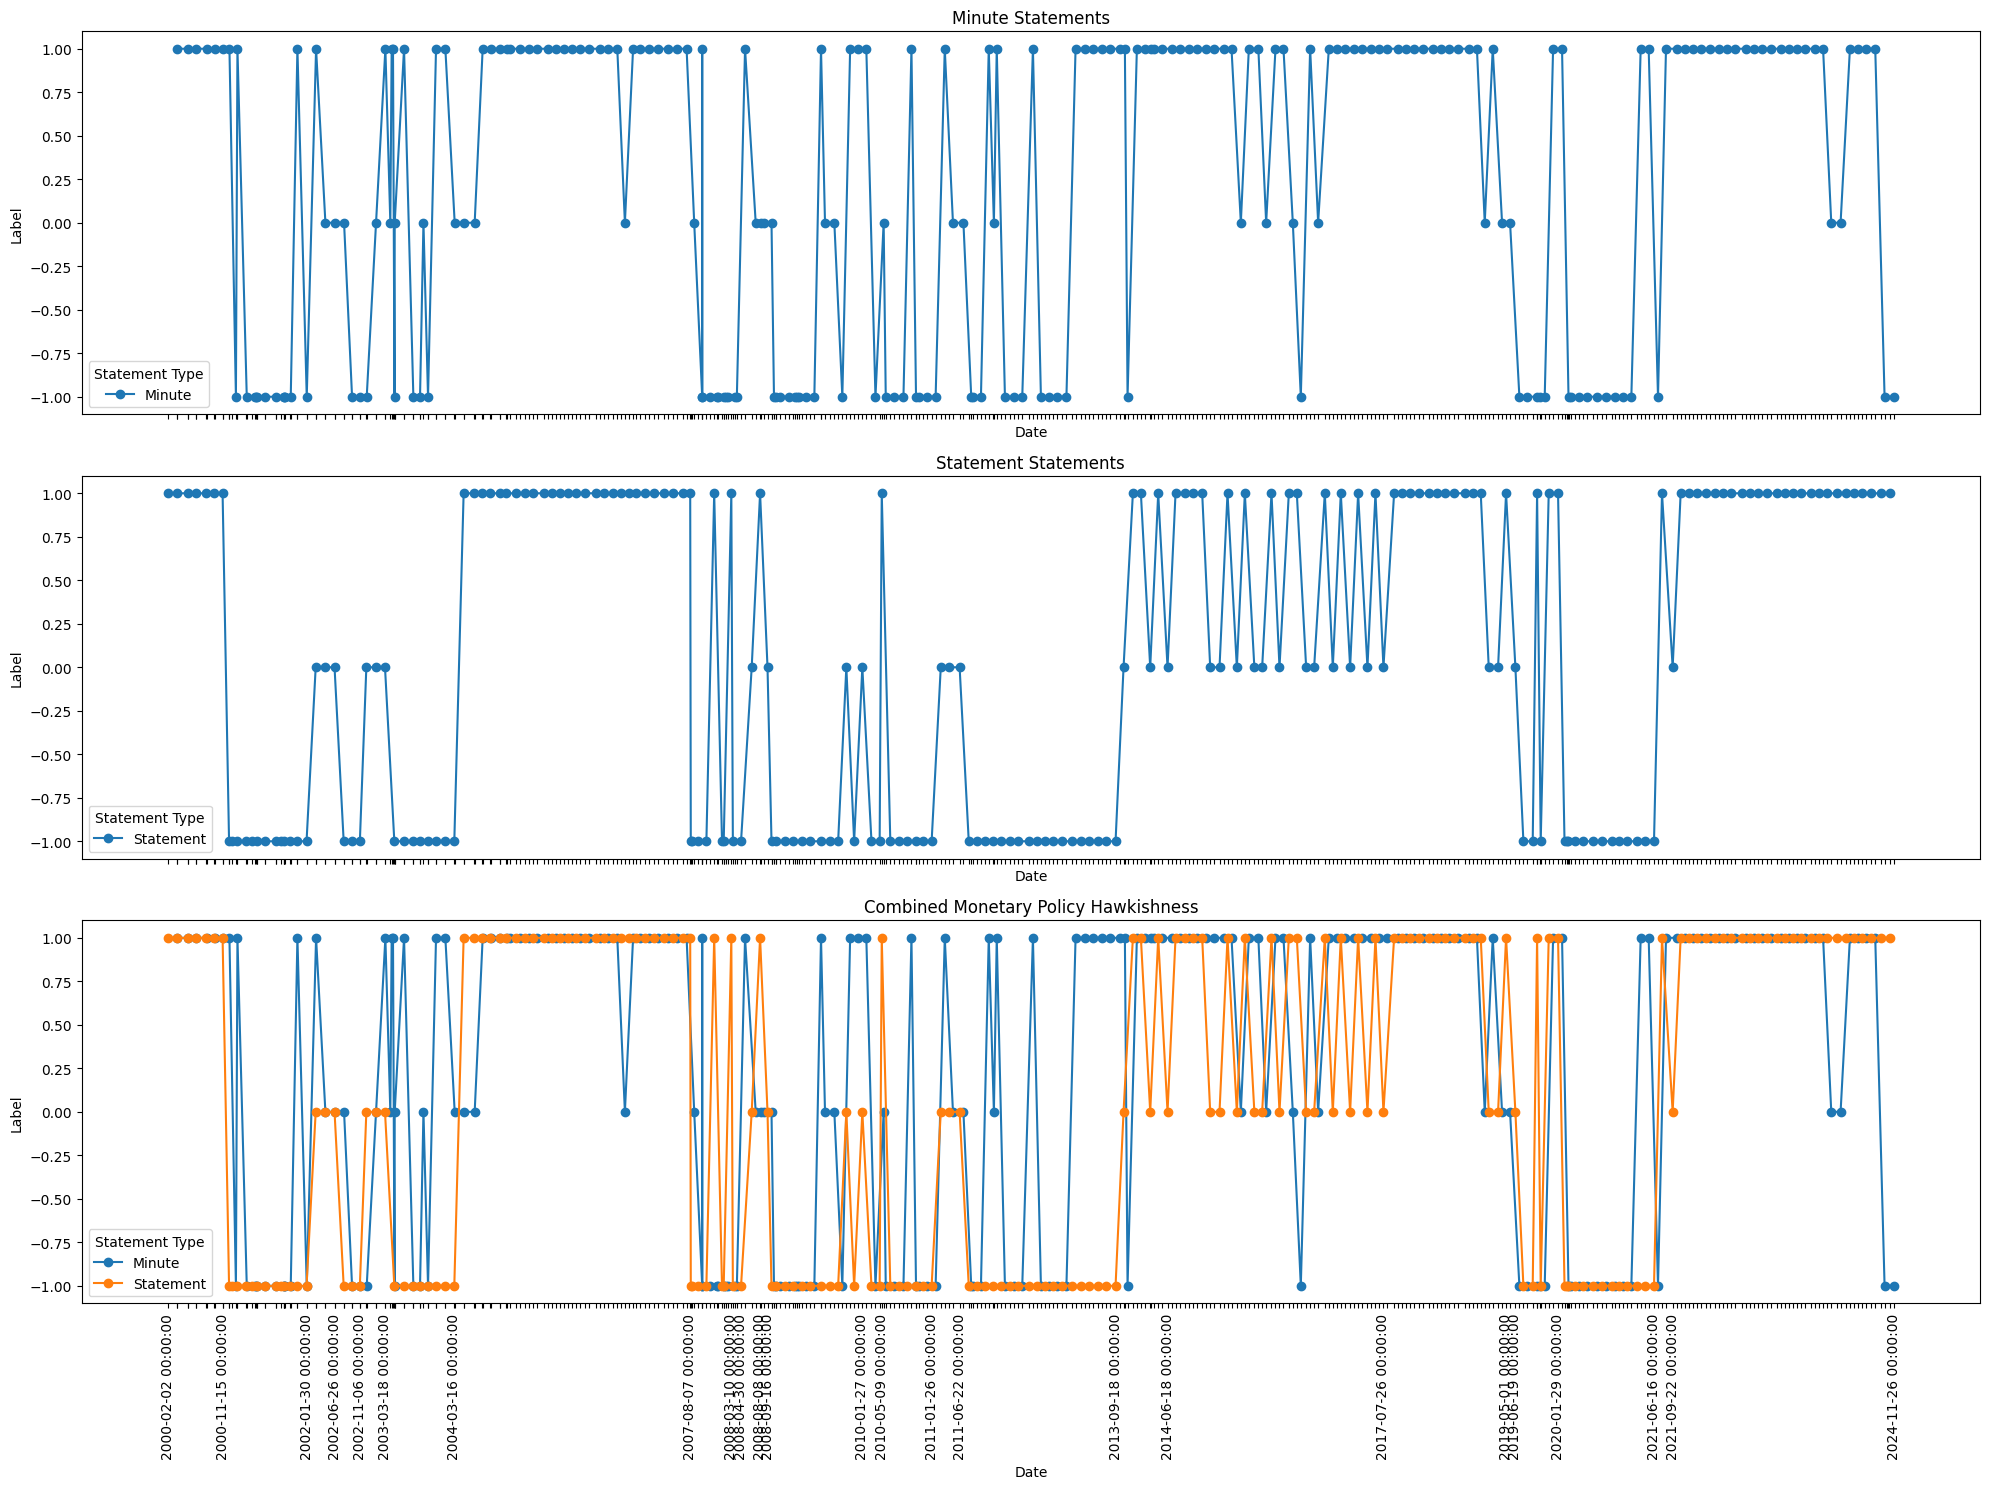

In [79]:
communications = process_checkpoint(checkpoint_com,communications)
plot_monetary_policy(communications,'label')

This is the Mistral analysis of the Fomc Statements and minutes:

The lack of relevant ground truth makes this graph hard to evaluate. The Georgia Tech's dataset contains etracted data that does not track months, just years. We can only try to compare this to other methods

In [16]:
tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt")

Device set to use cuda:0


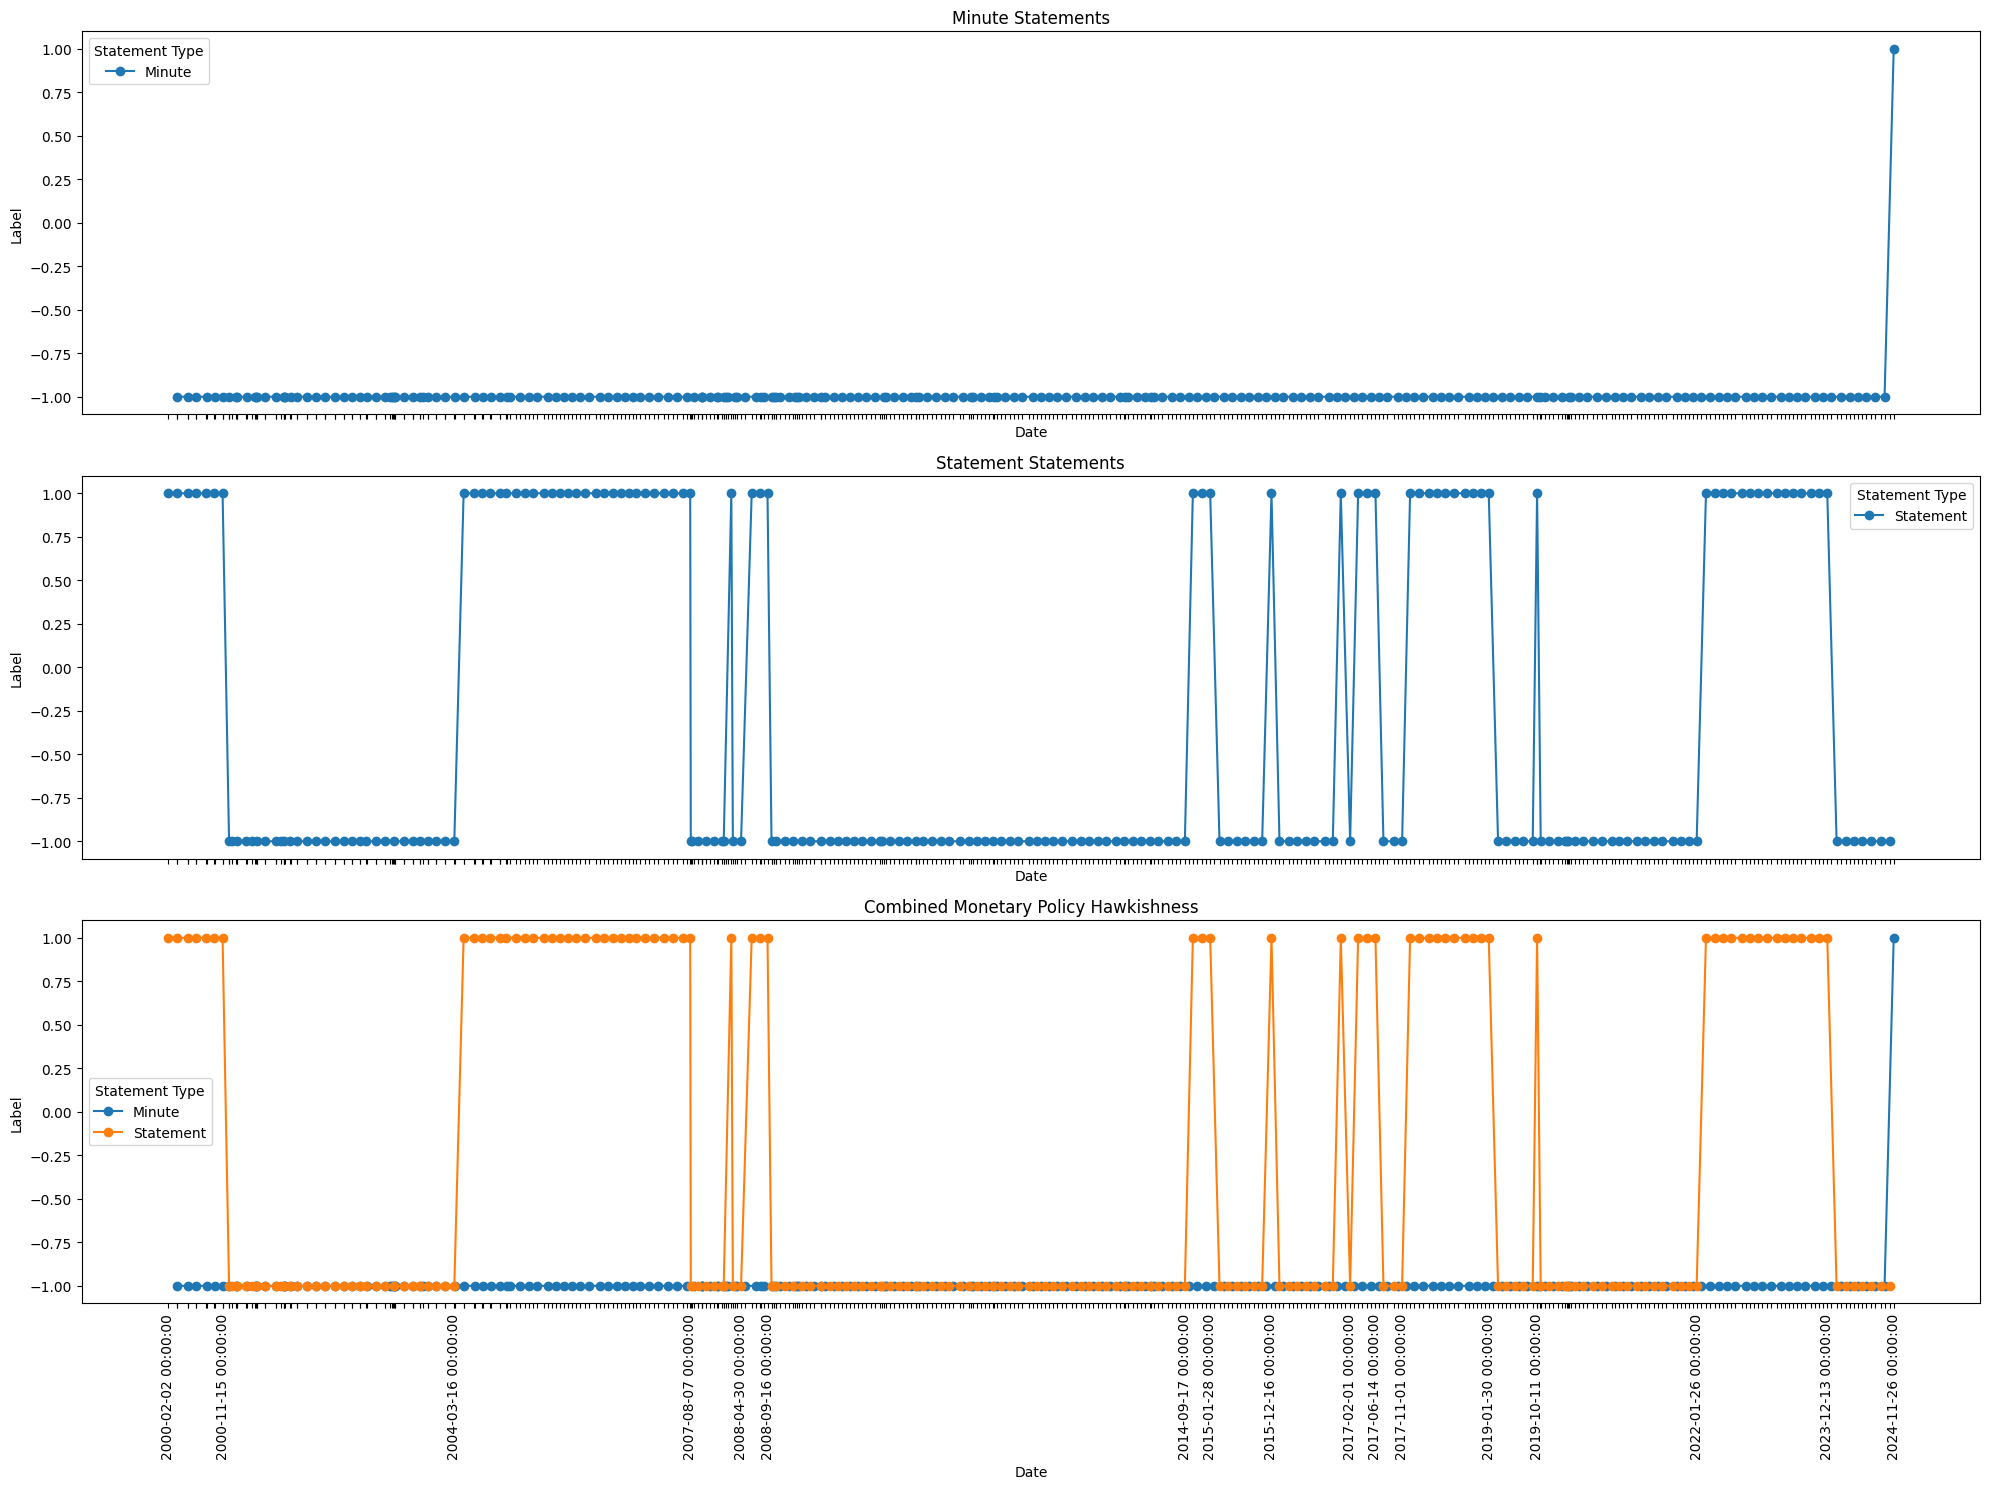

In [133]:
results = classifier(communications['Text'].tolist(),
                      batch_size=128, truncation="only_first")
communications['RoBERTa_label_raw']=pd.DataFrame(results)['label'].map({'LABEL_0':'dovish','LABEL_1':'hawkish','LABEL_2':'Neutral'})
communications['RoBERTa_probability_raw']=pd.DataFrame(results)['score']
plot_monetary_policy(communications,'RoBERTa_label_raw')

The Minutes text is too long for the roberta model ! we have two solutions:
- Break down the minutes text into sentences, het a label per sentence and average them to get an overall score for each entry

- Use Mistral's explanation/ summary to prompt Roberta

Solution 1: Breaking down sentences warning this takes 30 minutes

In [127]:
#TODO add loading checkpoint /recompute option

In [104]:
#we will now further split the minute data into sentences
minutes=communications[communications['Type']=='Minute']
# Step 1: Split paragraphs into sentences
minutes['Text'] = minutes['Text'].str.split('.')
# create two lists index and sentence where index keeps track of to which row the sentence belongs to
index = []
sentence = []
for i, row in minutes.iterrows():
    for s in row['Text']:
        if len(s) < 10:
            continue
        index.append(i)
        sentence.append(s)
        
results_broken_down = classifier(sentence,batch_size=256, truncation="only_first")

result_numeric=[{'LABEL_0': -1, 'LABEL_1': 1, 'LABEL_2': 0}.get(result['label']) for result in results_broken_down]

# Step 3: Aggregate the result_numeric according to the index
minutes['RoBERTa_label_raw'] = pd.Series(result_numeric).groupby(index).apply(lambda x: x.tolist())

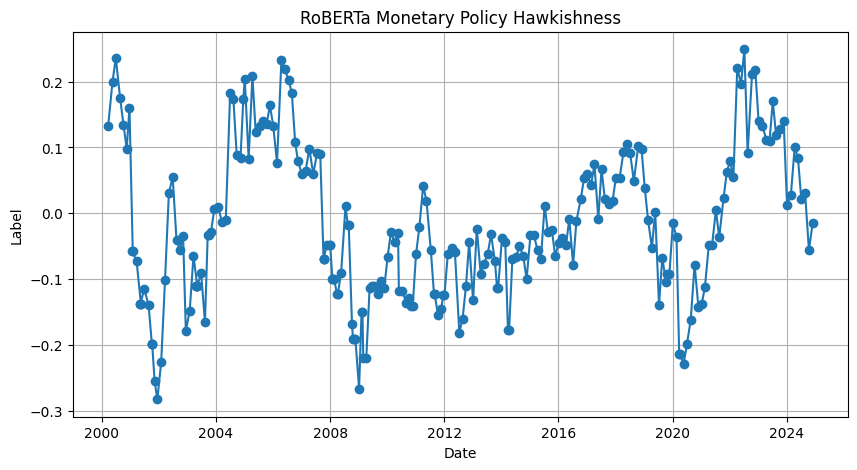

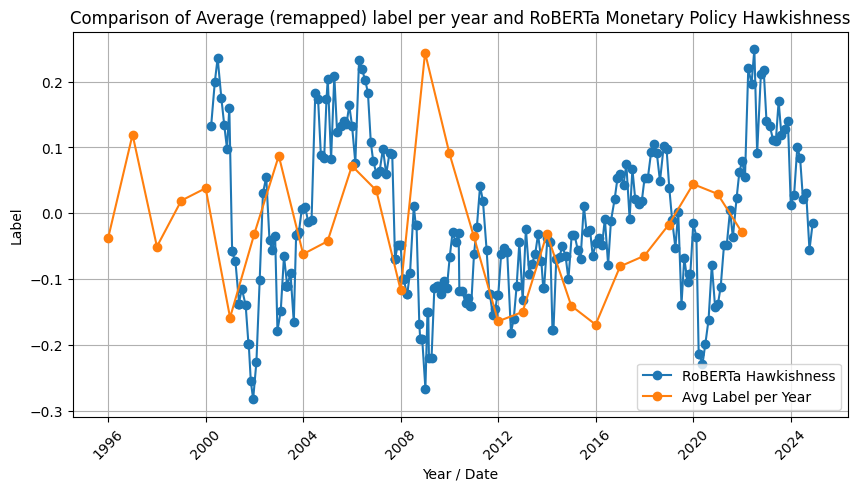

In [ ]:

georgia_tech_df['label_mapped'] = georgia_tech_df['label'].map({0: -1, 1: 1, 2: 0})
avg_label_per_year = georgia_tech_df.groupby('year')['label_mapped'].mean()
avg_label_df = avg_label_per_year.reset_index(name='Avg_Label')
avg_label_df['Date'] = pd.to_datetime(avg_label_df['year'], format='%Y')
avg_label_df
####################
plt.figure(figsize=(10, 5))
plt.plot(minutes['Date2'], minutes['RoBERTa_label_raw_broken_down'], marker='o')
plt.title('RoBERTa Monetary Policy Hawkishness')
plt.xlabel('Date')
plt.ylabel('Label')
plt.grid()
plt.show()
####################""
plt.figure(figsize=(10, 5))
plt.plot(minutes['Date2'], minutes['RoBERTa_label_raw_broken_down'], marker='o', label='RoBERTa Hawkishness')
plt.plot(avg_label_df['Date'], avg_label_df['Avg_Label'], marker='o', label='Avg Label per Year')
plt.title('Comparison of Average (remapped) label per year and RoBERTa Monetary Policy Hawkishness')
plt.xlabel('Year / Date')
plt.ylabel('Label')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()



This gives us scores that are similar to the ones we had by averaging scores per year in the Ground truth. We tried to overlay them to check for any kind of similar trends. But the period after 2008 seems to be completely wrong. as most of the GT's labels seem to indicate it's hawkish but The LLM says it's dovish with almost all methods.

Solutoin#2: Using the minutes explanation to prompt Roberta
This seems to create more cohesive predictions between minutes and statements. compared to when we used raw statments and raw minutes for Roberta. and even compared to when using raw statment and minutes for Mistral.

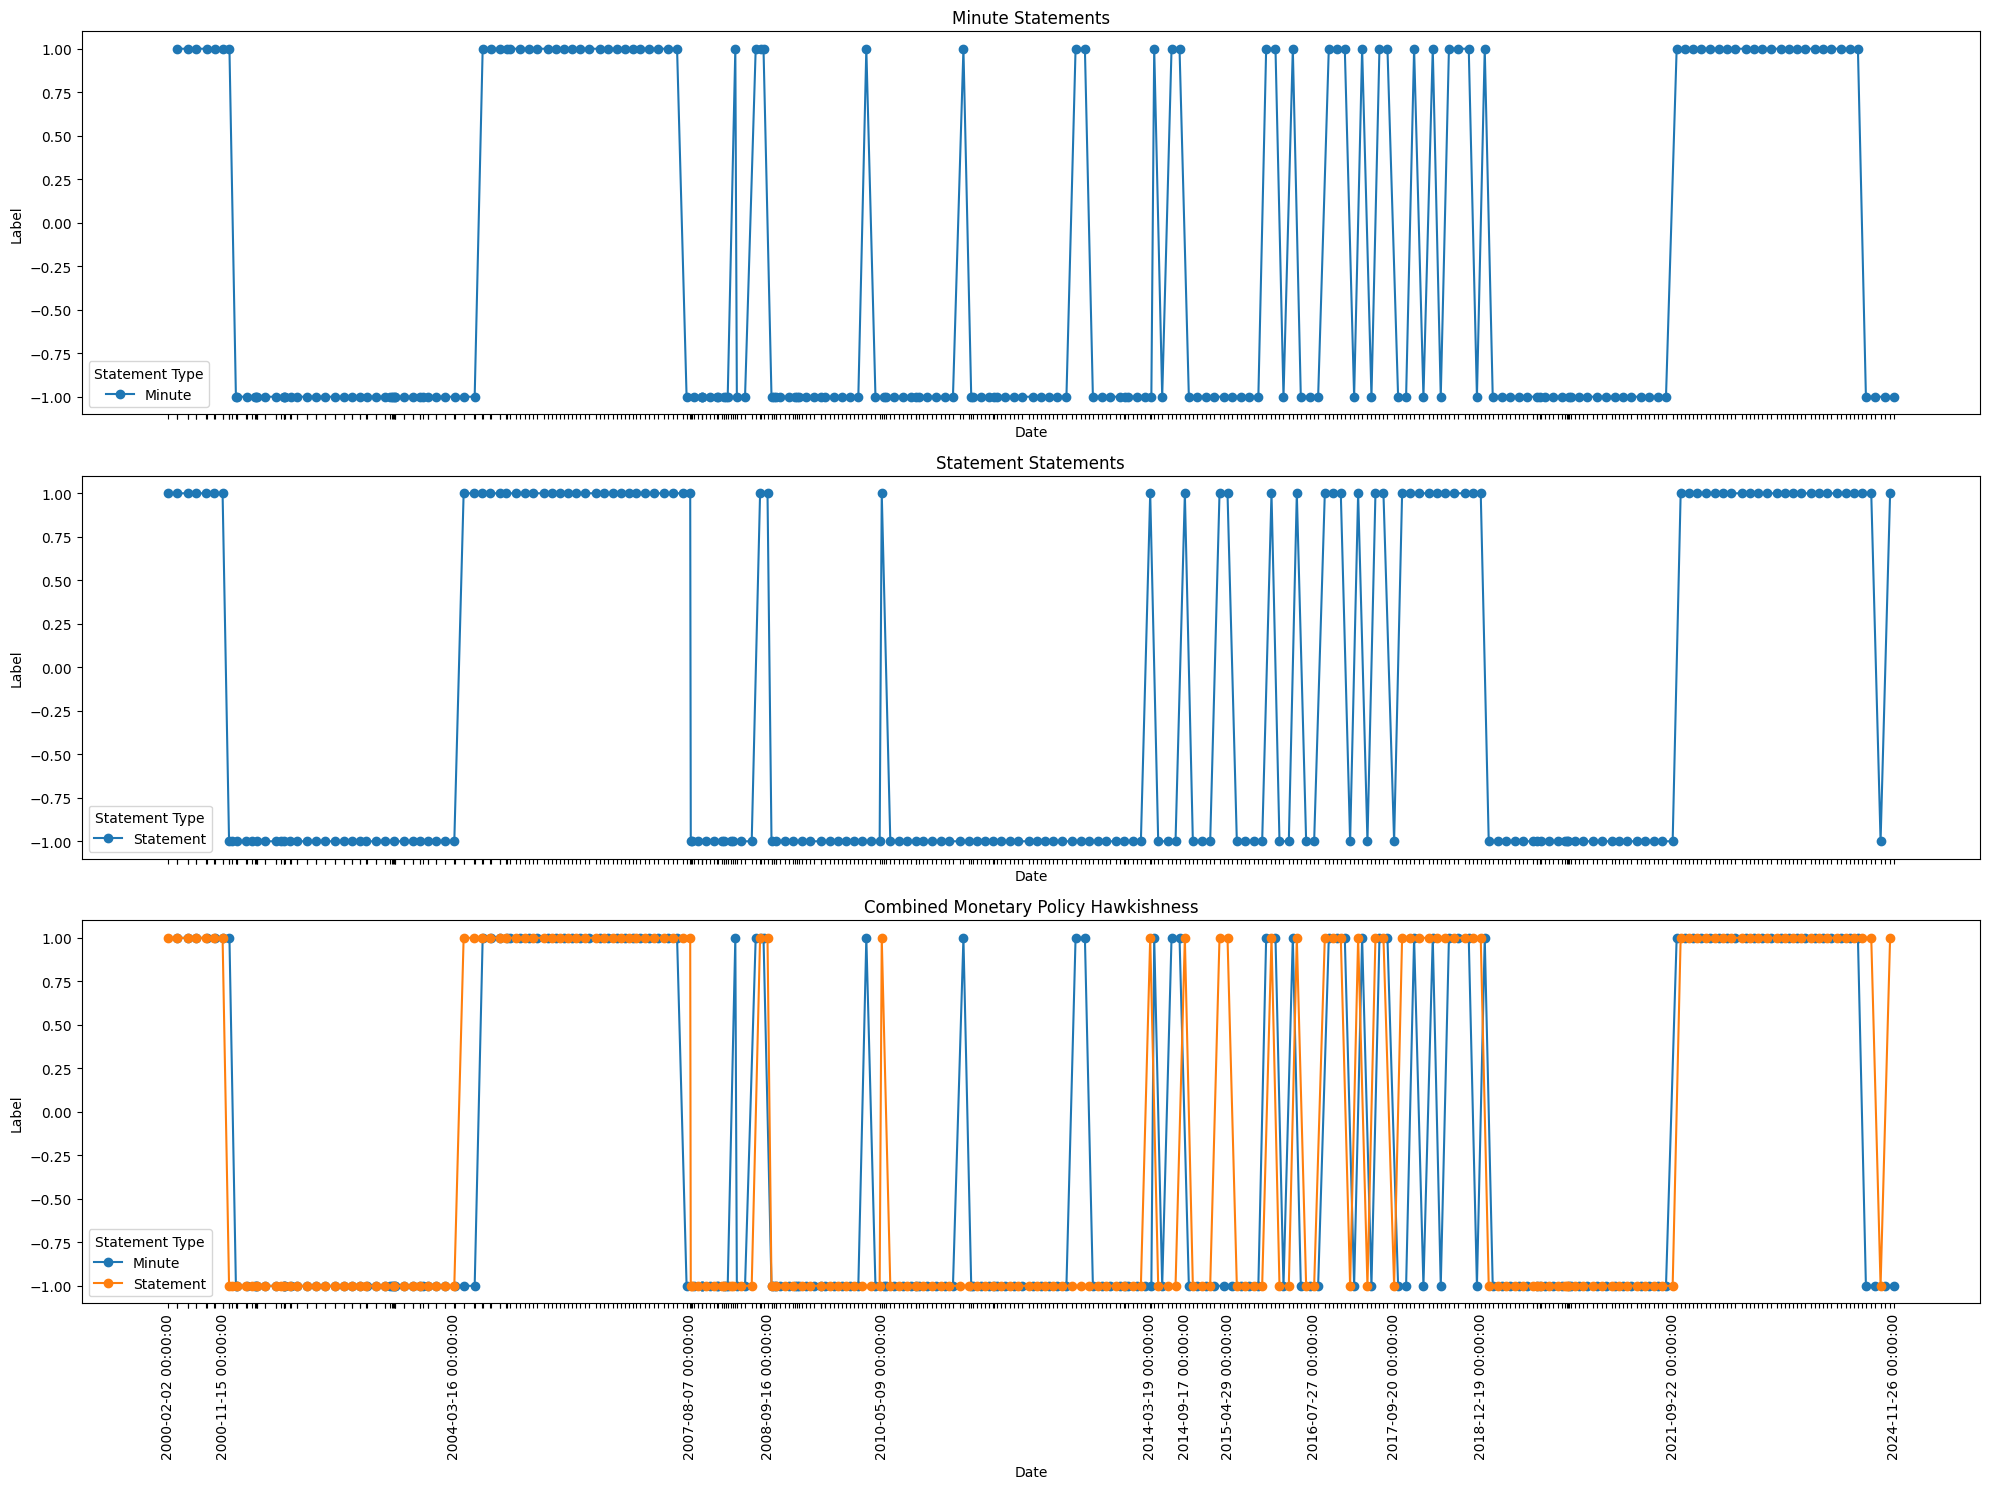

In [130]:
results_explanation = classifier(communications['Mistral_explanation'].tolist(),
                                    batch_size=128, truncation="only_first")
communications['RoBERTa_label_explanation']=pd.DataFrame(results_explanation)['label'].map({'LABEL_0':'dovish','LABEL_1':'hawkish','LABEL_2':'Neutral'})
communications['RoBERTa_probability_explanation']=pd.DataFrame(results_explanation)['score']
plot_monetary_policy(communications,'RoBERTa_label_explanation')

/tmp/ipykernel_1313/3140626907.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(categories, rotation=45)


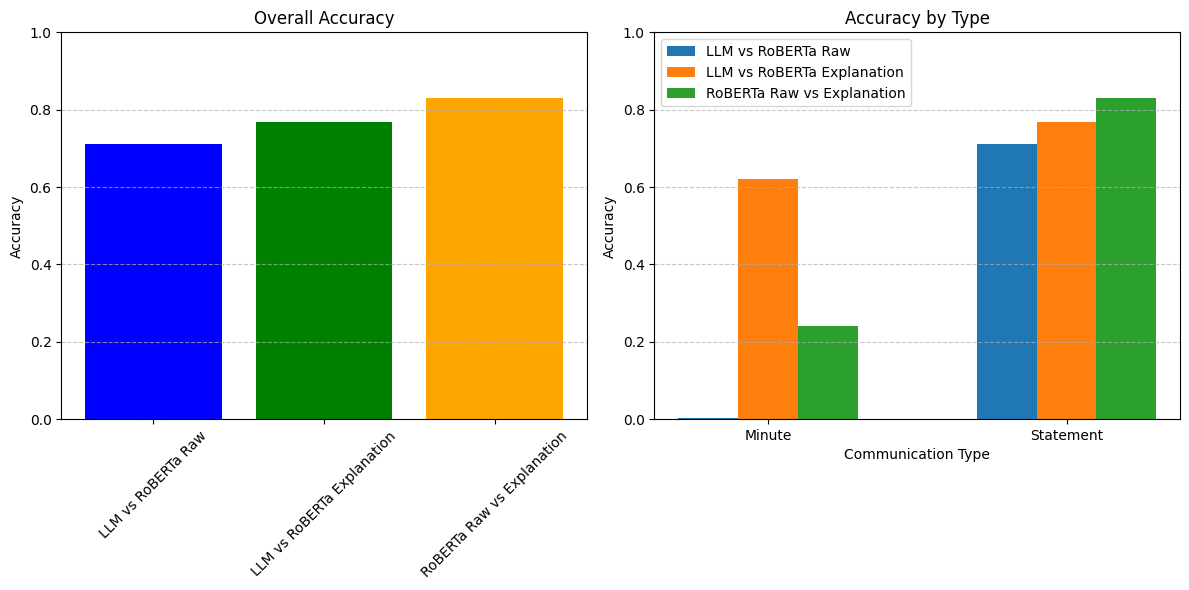

In [134]:
# Compute overall accuracies
acc_llm_roberta_raw = accuracy_score(communications['label'], communications['RoBERTa_label_raw'])
acc_llm_roberta_explanation = accuracy_score(communications['label'], communications['RoBERTa_label_explanation'])
acc_roberta_raw_roberta_explanation = accuracy_score(communications['RoBERTa_label_raw'], communications['RoBERTa_label_explanation'])

# Accuracy by type
types = ['Minute', 'Statement']
accuracies_by_type = {
    'LLM vs RoBERTa Raw': [],
    'LLM vs RoBERTa Explanation': [],
    'RoBERTa Raw vs Explanation': []
}

for t in types:
    acc_llm_roberta_raw = accuracy_score(
        communications[communications['Type'] == t]['label'], 
        communications[communications['Type'] == t]['RoBERTa_label_raw']
    )
    acc_llm_roberta_explanation = accuracy_score(
        communications[communications['Type'] == t]['label'], 
        communications[communications['Type'] == t]['RoBERTa_label_explanation']
    )
    acc_roberta_raw_roberta_explanation = accuracy_score(
        communications[communications['Type'] == t]['RoBERTa_label_raw'], 
        communications[communications['Type'] == t]['RoBERTa_label_explanation']
    )

    accuracies_by_type['LLM vs RoBERTa Raw'].append(acc_llm_roberta_raw)
    accuracies_by_type['LLM vs RoBERTa Explanation'].append(acc_llm_roberta_explanation)
    accuracies_by_type['RoBERTa Raw vs Explanation'].append(acc_roberta_raw_roberta_explanation)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Overall accuracies
categories = ['LLM vs RoBERTa Raw', 'LLM vs RoBERTa Explanation', 'RoBERTa Raw vs Explanation']
overall_accuracies = [acc_llm_roberta_raw, acc_llm_roberta_explanation, acc_roberta_raw_roberta_explanation]

ax[0].bar(categories, overall_accuracies, color=['blue', 'green', 'orange'])
ax[0].set_title('Overall Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)
#rotate text
ax[0].set_xticklabels(categories, rotation=45)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Accuracy by type
width = 0.2
x = np.arange(len(types))

for i, (key, values) in enumerate(accuracies_by_type.items()):
    ax[1].bar(x + i * width, values, width, label=key)

ax[1].set_title('Accuracy by Type')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Communication Type')
ax[1].set_xticks(x + width)
ax[1].set_xticklabels(types)
ax[1].legend()
ax[1].set_ylim(0, 1)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [135]:
#compute accuracy 
from sklearn.metrics import accuracy_score

acc_llm_roberta_raw=accuracy_score(communications['label'],communications['RoBERTa_label_raw'])
acc_llm_roberta_explanation=accuracy_score(communications['label'],communications['RoBERTa_label_explanation'])
acc_roberta_raw_roberta_explanation=accuracy_score(communications['RoBERTa_label_raw'],communications['RoBERTa_label_explanation'])
print(f'Accuracy of LLM vs RoBERTa raw: {acc_llm_roberta_raw}')
print(f'Accuracy of LLM vs RoBERTa explanation: {acc_llm_roberta_explanation}')
print(f'Accuracy of RoBERTa raw vs RoBERTa explanation: {acc_roberta_raw_roberta_explanation}')
#accuracy by type (Minute/ Statement)
print('\n'+'---'*20+'\n')
for t in ['Minute','Statement']:
    acc_llm_roberta_raw=accuracy_score(communications[communications['Type']==t]['label'],communications[communications['Type']==t]['RoBERTa_label_raw'])
    acc_llm_roberta_explanation=accuracy_score(communications[communications['Type']==t]['label'],communications[communications['Type']==t]['RoBERTa_label_explanation'])
    acc_roberta_raw_roberta_explanation=accuracy_score(communications[communications['Type']==t]['RoBERTa_label_raw'],communications[communications['Type']==t]['RoBERTa_label_explanation'])
    print(f'Accuracy of LLM vs RoBERTa raw for {t}: {acc_llm_roberta_raw}') 
    print(f'Accuracy of LLM vs RoBERTa explanation for {t}: {acc_llm_roberta_explanation}')
    print(f'Accuracy of RoBERTa raw vs RoBERTa explanation for {t}: {acc_roberta_raw_roberta_explanation}')
    print('\n'+'---'*20+'\n')

Accuracy of LLM vs RoBERTa raw: 0.3431818181818182
Accuracy of LLM vs RoBERTa explanation: 0.6909090909090909
Accuracy of RoBERTa raw vs RoBERTa explanation: 0.5227272727272727

------------------------------------------------------------

Accuracy of LLM vs RoBERTa raw for Minute: 0.004366812227074236
Accuracy of LLM vs RoBERTa explanation for Minute: 0.6200873362445415
Accuracy of RoBERTa raw vs RoBERTa explanation for Minute: 0.24017467248908297

------------------------------------------------------------

Accuracy of LLM vs RoBERTa raw for Statement: 0.7109004739336493
Accuracy of LLM vs RoBERTa explanation for Statement: 0.7677725118483413
Accuracy of RoBERTa raw vs RoBERTa explanation for Statement: 0.8293838862559242

------------------------------------------------------------



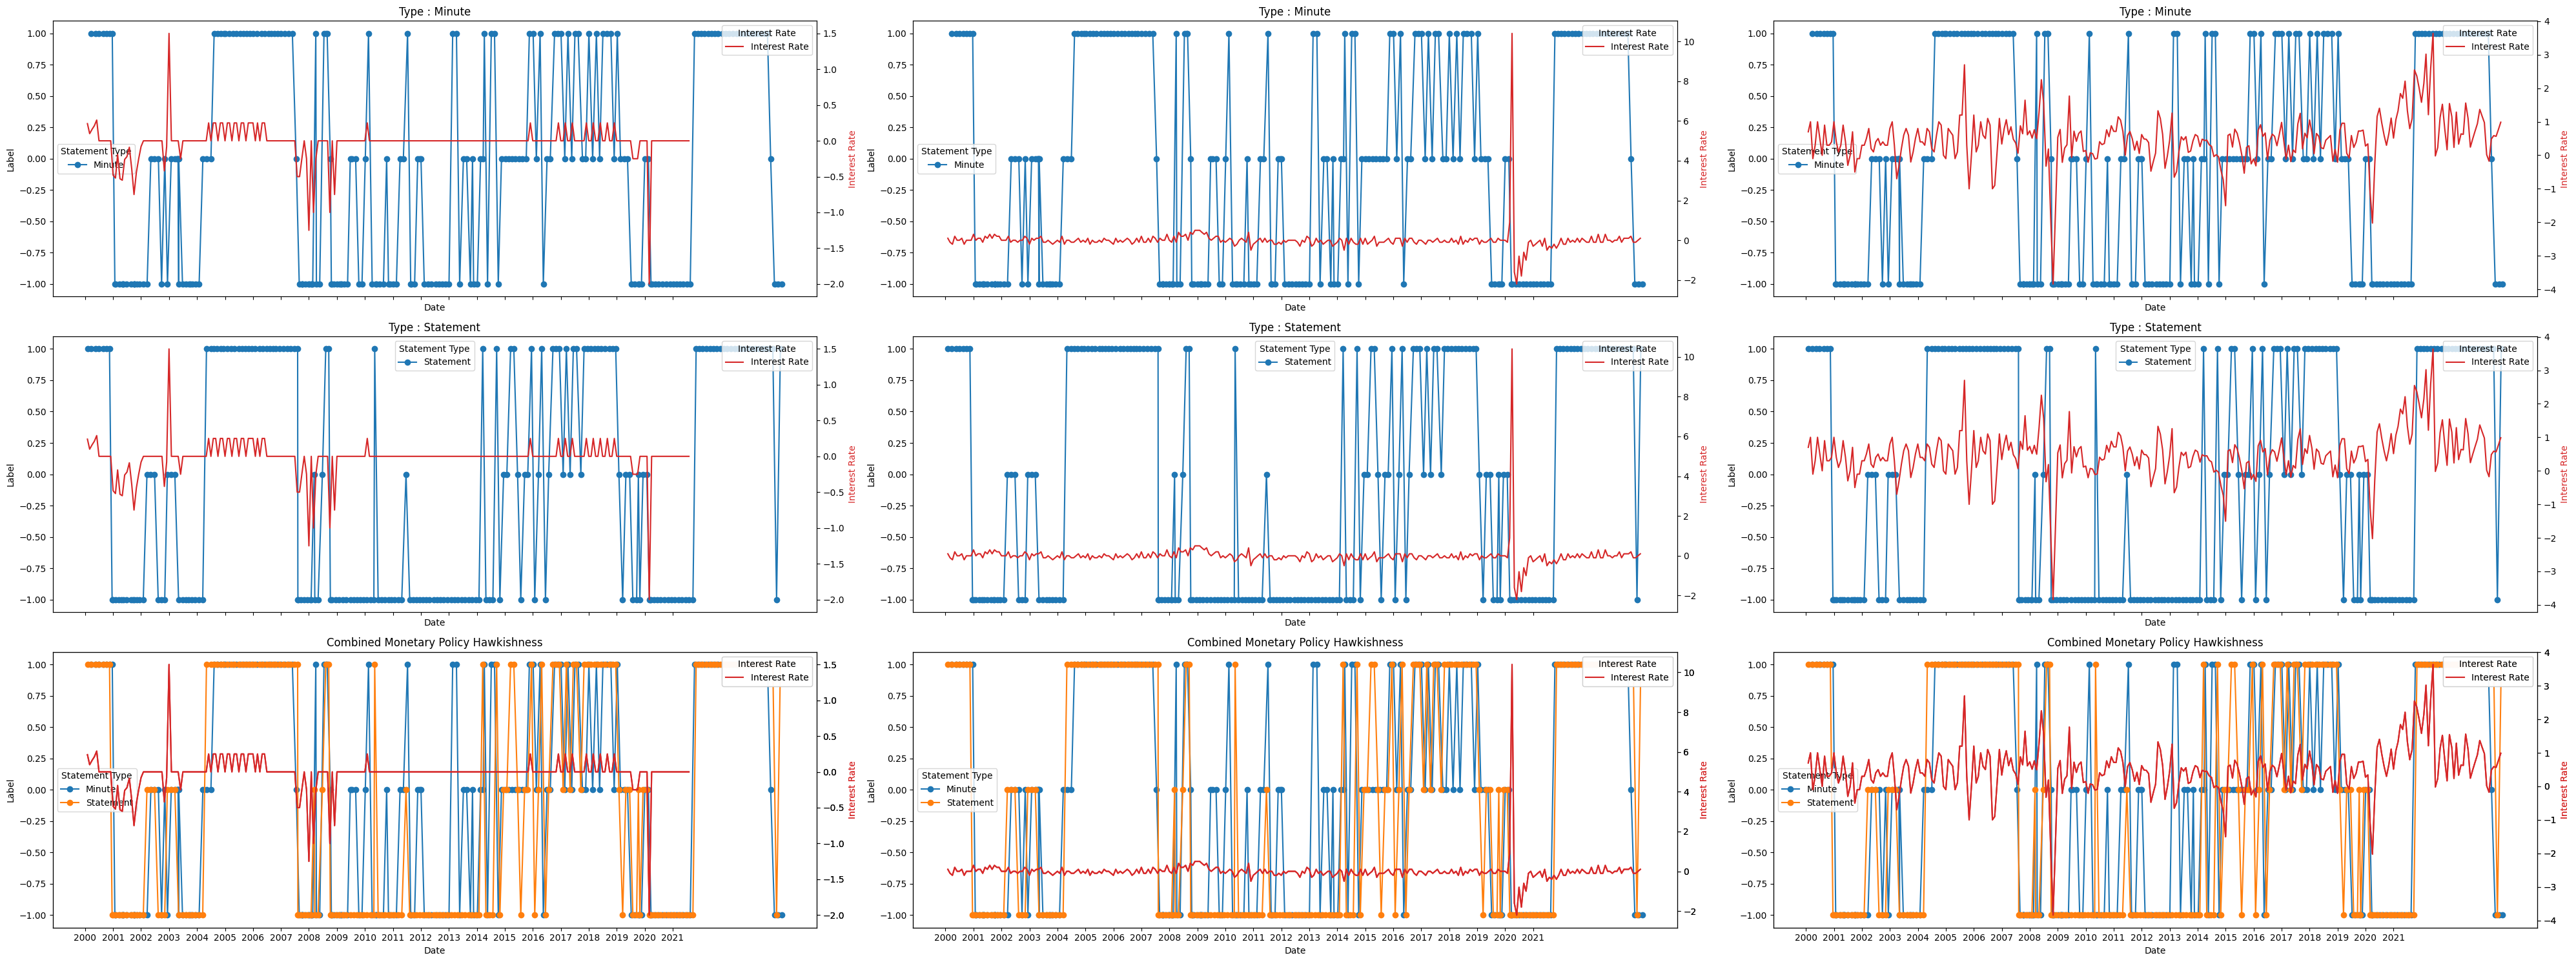

In [137]:
df=copy.deepcopy(communications)
# Ensure Date2 is datetime and sorted
df['Date2'] = pd.to_datetime(df['Release Date'])
df = df.sort_values(by='Date2', ascending=False)


# Encode labels
df['label2'] = df['RoBERTa_label_explanation'].apply(lambda x: 1 if x == 'hawkish' else 0 if x == 'Neutral' else -1)

# # Identify important shifts
# Dates = check_important_shift_dates(df, 5)

# Initialize subplots
fig, axes = plt.subplots(3, 3, figsize=(40, 15), sharex=True)

# Plot each statement type separately
for i, (statement_type, group_df) in enumerate(df.groupby('Type')):
        for j, variable in enumerate([Int_R,UR,CPI]):
            axes[i,j].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
            axes[i,j].set_title(f'Type : {statement_type}')
            axes[i,j].set_xlabel('Date')
            axes[i,j].set_ylabel('Label')
            axes[i,j].legend(title="Statement Type")
            
            ax2 = axes[i,j].twinx()  # This creates a second y-axis sharing the same x-axis
            ax2.plot(variable['observation_date'], variable['evolution'], color='tab:red', label='Interest Rate')
            ax2.set_ylabel('Interest Rate', color='tab:red')  # Set the y-axis label for the second plot
            ax2.set_xticks(jan_first_dates)
            ax2.set_xticklabels(jan_first_dates.dt.strftime('%Y'), rotation=45, ha='right')
    
            # Optional: Set a legend for the second y-axis
            ax2.legend(title="Interest Rate", loc='upper right')
            
            
            

# Plot both together in the last subplot
for statement_type, group_df in df.groupby('Type'):
    for j, variable in enumerate([Int_R,UR,CPI]):
        axes[2,j].plot(group_df['Date2'], group_df['label2'], marker='o', label=statement_type)
        axes[2,j].set_title('Combined Monetary Policy Hawkishness')
        axes[2,j].set_xlabel('Date')
        axes[2,j].set_ylabel('Label')
        axes[2,j].legend(title="Statement Type")

        ax2 = axes[2,j].twinx()
        ax2.plot(variable['observation_date'], variable['evolution'], color='tab:red', label='Interest Rate')
        ax2.set_ylabel('Interest Rate', color='tab:red')
        ax2.set_xticks(jan_first_dates)
        ax2.set_xticklabels(jan_first_dates.dt.strftime('%Y'), rotation=45, ha='right')
        ax2.legend(title="Interest Rate", loc='upper right')
        
        

# Show the plots
plt.tight_layout()
plt.show()

In [138]:
from dateutil.relativedelta import relativedelta

def check_months_apart(dates, x,months,before):
    if len(dates) < months:
        return False
    # print(dates)
    # print(x)
    # print(dates.iloc[-1])
    # print((x - dates.iloc[-1]))
    # print('-------------------')
    return (x - dates.iloc[-1]).days >= (months-1)*30 if before else (dates.iloc[-1] - x).days >= (months-1)*30

def calculate_evolution(df, date_col, value_col, x,months, before=True):
    filtered_df = df[df[date_col] <= x] if before else df[df[date_col] >= x]
    sorted_df = filtered_df.sort_values(by=date_col, ascending=not before).head(months)
    if check_months_apart(sorted_df[date_col], x,months,before):
        # print(f"Date: {x} - Sum: {round(sorted_df[value_col].sum(), 2)}")
        # print(sorted_df)
        return round(sorted_df[value_col].sum(), 2)
    return np.nan

for months in [3, 6, 12]:
    for before in [True, False]:
        print(f"Months: {months} - Before: {before}")
        df[f"i_r_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(Int_R, 'observation_date', 'evolution', x, months, before)
        )
        df[f"cpi_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(CPI, 'observation_date', 'evolution', x, months, before)
        )
        df[f"u_r_{months}_{'before' if before else 'after'}"] = df['Date2'].apply(
            lambda x: calculate_evolution(UR, 'observation_date', 'evolution', x, months, before)
        )
#number of nan rows in the columns that contains Nans
print(f' We created features aggregating the evolution for the 3, 6 and 12 months before AND after the monetary policy statement. \n')

df.isnull().sum()[df.isnull().sum()>0]

Months: 3 - Before: True
Months: 3 - Before: False
Months: 6 - Before: True
Months: 6 - Before: False
Months: 12 - Before: True
Months: 12 - Before: False
 We created features aggregating the evolution for the 3, 6 and 12 months before AND after the monetary policy statement. 



i_r_3_before      1
cpi_3_before      1
u_r_3_before      1
i_r_3_after      58
cpi_3_after       7
u_r_3_after       7
i_r_6_before      5
cpi_6_before      5
u_r_6_before      5
i_r_6_after      60
cpi_6_after       8
u_r_6_after       8
i_r_12_before    13
cpi_12_before    13
u_r_12_before    13
i_r_12_after     68
cpi_12_after     16
u_r_12_after     16
dtype: int64

In [139]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score
df_dropped_na=df.dropna()
def evaluate_kmeans(df,clustering_algorithms):
    # Drop missing values
    df_dropped_na = df.dropna()

    # Define feature combinations
    feature_sets = {
        'features_3_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before'],
        'features_3_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_3_all': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before', 'i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_6_before': ['i_r_6_before', 'cpi_6_before', 'u_r_6_before'],
        'features_6_after': ['i_r_6_after', 'cpi_6_after', 'u_r_6_after'],
        'features_6_all': ['i_r_6_before', 'cpi_6_before', 'u_r_6_before', 'i_r_6_after', 'cpi_6_after', 'u_r_6_after'],
        'features_12_before': ['i_r_12_before', 'cpi_12_before', 'u_r_12_before'],
        'features_12_after': ['i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_12_all': ['i_r_12_before', 'cpi_12_before', 'u_r_12_before', 'i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_after', 'cpi_12_after', 'u_r_12_after'],
        'features_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before','i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_12_before', 'cpi_12_before', 'u_r_12_before'],
        'features_all':['i_r_3_before', 'cpi_3_before', 'u_r_3_before','i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_12_before', 'cpi_12_before', 'u_r_12_before','i_r_3_after', 'cpi_3_after', 'u_r_3_after','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_after', 'cpi_12_after', 'u_r_12_after']
    }

    results = {}

    for name, features in feature_sets.items():
        # Extract features
        X = df_dropped_na[features]
        # Compute accuracies with label switching
        true_labels = df_dropped_na['label2'].values
        

        for algo_name, algorithm in clustering_algorithms.items():
            # Fit clustering algorithm
            model = algorithm.fit(X)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X)

            # Compute accuracies with label switching
            acc1 = accuracy_score(true_labels, [-1 if x == 0 else 0 if x == 1 else 1 for x in labels])
            acc2 = accuracy_score(true_labels, labels)
            acc3 = accuracy_score(true_labels, [1 if x == 0 else 0 if x == 1 else -1 for x in labels])

            best_accuracy = max(acc1, acc2, acc3)
            results[f'{name}_{algo_name}'] = {
                'acc_original': acc2,
                'acc_switch_1': acc1,
                'acc_switch_2': acc3,
                'best_accuracy': best_accuracy
            }

    # Sort results by best accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True))
    
    best_accuracy,best_features=sorted_results[list(sorted_results.keys())[0]]['best_accuracy'],list(sorted_results.keys())[0]
    return sorted_results,best_accuracy,best_features

# Example usage
best_results,best_accuracy,best_features = evaluate_kmeans(df, {
    'kmeans': KMeans(n_clusters=3, random_state=0),
    'agg': AgglomerativeClustering(n_clusters=3),
    'dbscan': DBSCAN(eps=0.5, min_samples=5)
})
print(f"Best accuracy: {best_accuracy}")
print(f"Best features: {best_features}")


Best accuracy: 0.5014005602240896
Best features: features_3_all_dbscan


In [140]:
# The "best" predictions are those with 3 months before and after drop 6 and 12 months
df.drop(['i_r_6_before', 'cpi_6_before', 'u_r_6_before','i_r_6_after', 'cpi_6_after', 'u_r_6_after','i_r_12_before', 'cpi_12_before', 'u_r_12_before','i_r_12_after', 'cpi_12_after', 'u_r_12_after'], axis=1, inplace=True)
    

In [141]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score
df_dropped_na=df.dropna()
def evaluate_kmeans(df,clustering_algorithms):
    # Drop missing values
    df_dropped_na = df.dropna()

    # Define feature combinations
    feature_sets = {
        'features_3_before': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before'],
        'features_3_after': ['i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
        'features_3_all': ['i_r_3_before', 'cpi_3_before', 'u_r_3_before', 'i_r_3_after', 'cpi_3_after', 'u_r_3_after'],
    }

    results = {}

    for name, features in feature_sets.items():
        # Extract features
        X = df_dropped_na[features]
        # Compute accuracies with label switching
        true_labels = df_dropped_na['label2'].values
        

        for algo_name, algorithm in clustering_algorithms.items():
            # Fit clustering algorithm
            model = algorithm.fit(X)
            labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X)

            # Compute accuracies with label switching
            acc1 = accuracy_score(true_labels, [-1 if x == 0 else 0 if x == 1 else 1 for x in labels])
            acc2 = accuracy_score(true_labels, labels)
            acc3 = accuracy_score(true_labels, [1 if x == 0 else 0 if x == 1 else -1 for x in labels])

            best_accuracy = max(acc1, acc2, acc3)
            results[f'{name}_{algo_name}'] = {
                'acc_original': acc2,
                'acc_switch_1': acc1,
                'acc_switch_2': acc3,
                'best_accuracy': best_accuracy
            }

    # Sort results by best accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True))
    
    best_accuracy,best_features=sorted_results[list(sorted_results.keys())[0]]['best_accuracy'],list(sorted_results.keys())[0]
    return sorted_results,best_accuracy,best_features

# Example usage
best_results,best_accuracy,best_features = evaluate_kmeans(df, {
    'kmeans': KMeans(n_clusters=3, random_state=0),
    'agg': AgglomerativeClustering(n_clusters=3),
    'dbscan': DBSCAN(eps=0.5, min_samples=5)
})
print(f"Best accuracy: {best_accuracy}")
print(f"Best features: {best_features}")


Best accuracy: 0.5328083989501312
Best features: features_3_all_dbscan


'___'

In [146]:
checkpoint_georgia_tech=analyze_monetary_policy(georgia_tech_df,api_key,prompt_mistral=False,use_checkpoints=True,data_name='georgia_tech_df')
georgia_tech_df['label_mistral']=checkpoint_georgia_tech['text'].apply(lambda x: extract_label(x, numeric=True))
georgia_tech_df['Mistral_explanation']=checkpoint_georgia_tech['text'].apply(lambda x: x.split('explanation: ')[1].strip() if x.find('explanation') != -1 else x.split('Explanation: ')[1].strip())

In [148]:
#get accuracy
a_s=accuracy_score(georgia_tech_df['label'],georgia_tech_df['label_mistral'])
print(f'The accuracy of the LLM is {a_s}')
#confusion matrix
from sklearn.metrics import confusion_matrix    

c_m=confusion_matrix(georgia_tech_df['label'],georgia_tech_df['label_mistral'])
print(f'The confusion matrix is \n {c_m}')
print(f'for row 0 the precision is {c_m[0,0]/c_m[0].sum()}. ie the percentage of dovish that are correctly classified.')
print(f'for row 1 the precision is {c_m[1,1]/c_m[1].sum()}. ie the percentage of hawkish that are correctly classified.')
print(f'for row 2 the precision is {c_m[2,2]/c_m[2].sum()}. ie the percentage of neutral that are correctly classified.')

The accuracy of the LLM is 0.521774193548387
The confusion matrix is 
 [[337 147 166]
 [ 71 371 164]
 [198 440 586]]
for row 0 the precision is 0.5184615384615384. ie the percentage of dovish that are correctly classified.
for row 1 the precision is 0.6122112211221122. ie the percentage of hawkish that are correctly classified.
for row 2 the precision is 0.47875816993464054. ie the percentage of neutral that are correctly classified.


In [149]:
#generate random samples of the same size as the gt
import random
a_s=[]
for i in range(1000):
    a_s.append(accuracy_score(georgia_tech_df['label'],random.choices([0,1,2],k=len(georgia_tech_df))))
print(f'The accuracy of the random samples is {np.mean(a_s)}')

The accuracy of the random samples is 0.3331758064516129


In [150]:
# Applying roberta to the same data 
roberta_raw_gt=classifier(georgia_tech_df['sentence'].tolist(),batch_size=128, truncation="only_first")
roberta_explanation_gt=classifier(georgia_tech_df['Mistral_explanation'].tolist(),batch_size=128, truncation="only_first")

georgia_tech_df['RoBERTa_label_raw']=pd.DataFrame(roberta_raw_gt)['label'].map({'LABEL_0':0,'LABEL_1':1,'LABEL_2':2})
georgia_tech_df['RoBERTa_label_explanation']=pd.DataFrame(roberta_explanation_gt)['label'].map({'LABEL_0':0,'LABEL_1':1,'LABEL_2':2})

#compute accuracy

acc_llm_roberta_raw=accuracy_score(georgia_tech_df['label'],georgia_tech_df['RoBERTa_label_raw'])
acc_llm_roberta_explanation=accuracy_score(georgia_tech_df['label'],georgia_tech_df['RoBERTa_label_explanation'])
print(f'Accuracy of LLM vs RoBERTa raw: {acc_llm_roberta_raw}')
print(f'Accuracy of LLM vs RoBERTa explanation: {acc_llm_roberta_explanation}')

accuracy_score(georgia_tech_df['label'].iloc[:len(df_train)],georgia_tech_df['RoBERTa_label_raw'].iloc[:len(df_train)])

Accuracy of LLM vs RoBERTa raw: 0.8270161290322581
Accuracy of LLM vs RoBERTa explanation: 0.6129032258064516


0.9395161290322581